In [3]:
from ripser import ripser
from persim import plot_diagrams
import numpy as np
from numpy import pi,cos,sin
import matplotlib.pyplot as plt
import random


import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
def get_pixels(num_pixels, window_size):
    sample = list(np.linspace(-window_size/2, window_size/2, num_pixels))
    pixels = []
    for i in range(len(sample)):
        for j in range(len(sample)):
            pixels.append((sample[i],sample[j]))     
    return pixels


def get_colors(pixels, image_function):
    colors = []
    for pixel in pixels:
        colors.append(image_function(pixel[0],pixel[1]))
    return colors  

def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

def generate_isom(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(2 * pi * np.random.random(n_isos)) # sampling from (0, 2pi)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

def new_colors(pixels, iso_inv, image_function):
    pixels_inv = []
    for pixel in pixels: 
        pixels_inv.append(iso_inv(pixel[0], pixel[1]))
    new_colors = get_colors(pixels_inv, image_function)
    return new_colors

def matrix_of_images(pixels, isos_inv, image_function):
    vectors = []
    for i in isos_inv:
        vectors.append([new_colors(pixels, i, image_function)])
    M = np.concatenate(vectors, axis=0 )
    return M

def p_hom(M, maxdim, coeff):
    output = ripser(M, maxdim = maxdim, coeff = coeff)
    return output
    
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d

def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)
    
def pipeline(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

def graph(image_function, x, y, x_random = True, n_samples= 100000, y_random = True):
    
    if x_random == True:
        X = list(2 * x * np.random.random(n_samples) - x) 
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)      

    if x_random == False:
        X = np.linspace(-x,x,n_samples)
        if y_random == True:
            Y = list(2 * y * np.random.random(n_samples) - y) 
        else:
            Y = np.linspace(-y,y,n_samples)   

    points = []
    for i in range(n_samples):
        color = image_function(X[i],Y[i])
        if color == 1:
            points.append((X[i],Y[i])) 
        
    x_points = []
    y_points = []
    for i in points: 
        x_points.append(i[0])
        y_points.append(i[1])
        
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points)
    plt.show()
    
def view_window(image_function, num_pixels, window_size):
    
    pixels = get_pixels(num_pixels, window_size)

    points = []
    for pixel in pixels:
        color = image_function(pixel[0],pixel[1])
        if color == 1:
            points.append(pixel)
    
    x_points = []
    y_points = []
    for pixel in points:
        x_points.append(pixel[0])
        y_points.append(pixel[1])
    
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points)
    plt.show()

## Goal: make a C2 function

In [3]:
def sine(x,y):
    ret = 0
    for a in range(-10,10):
        if sin(x) - 0.1 + 2*a <= y <= sin(x) + 0.1 + 2*a:
            ret = 1
    return ret

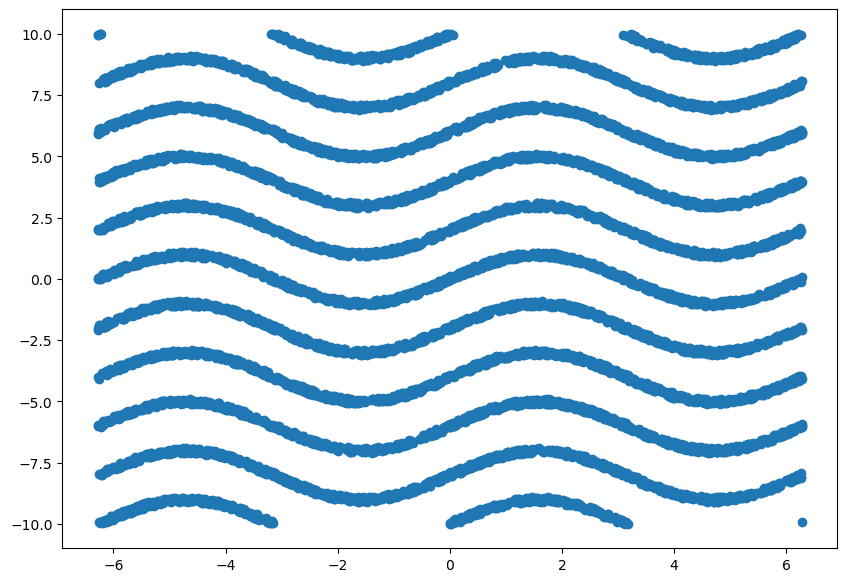

In [4]:
graph(sine, 2 * pi, 10, x_random = True, n_samples= 100000, y_random = True)

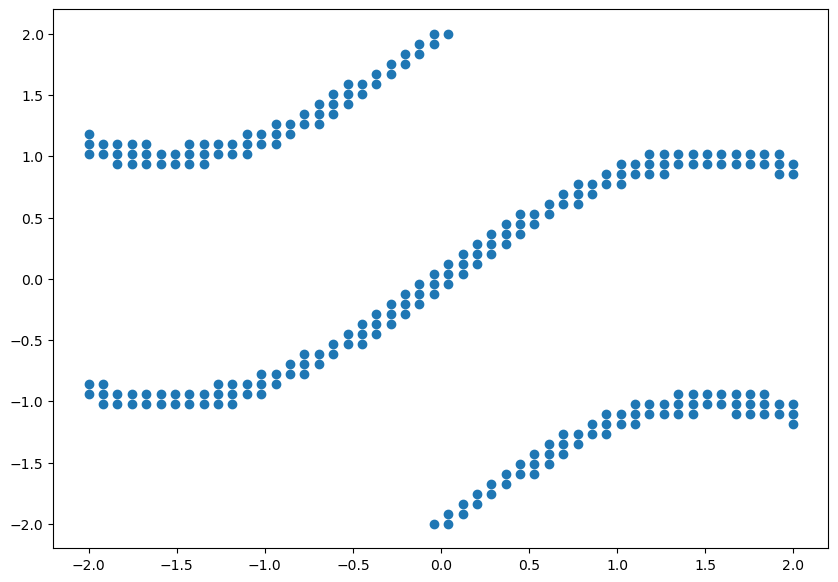

In [144]:
view_window(sine, 50, 4)

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


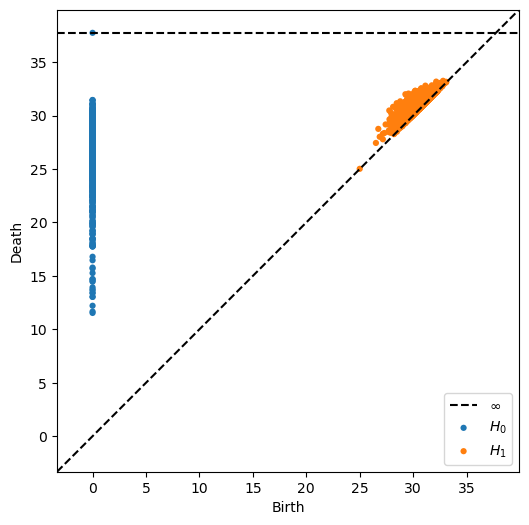

In [6]:
output = pipeline(image_function = sine, num_pixels = 80, window_size = 4, n_isos= 1000, x_translate = 5, y_translate = 5, maxdim=1, coeff=2)
plot_dgms(output)

**Looking at just translations**

In [5]:
def generate_isom_trans(n_isos, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_isos) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_isos) - y_translate) # sampling from (-y,y)
    theta = list(np.zeros(2*n_isos)) 

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv


def pipeline_trans(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom_trans(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


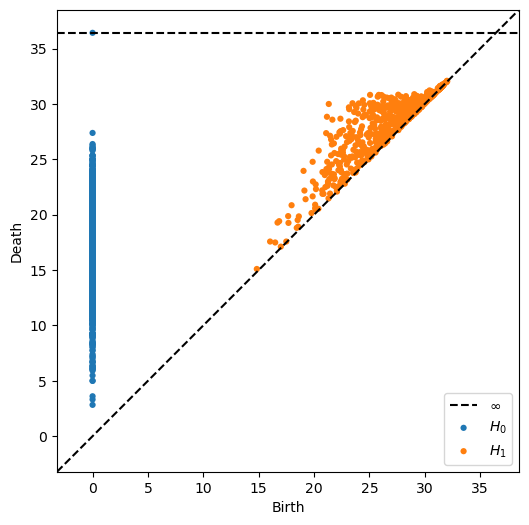

In [6]:
output = pipeline_trans(image_function = sine, num_pixels = 80, window_size = 4, n_isos= 1000, x_translate = 5, y_translate = 5, maxdim=1, coeff=2)
plot_dgms(output)

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


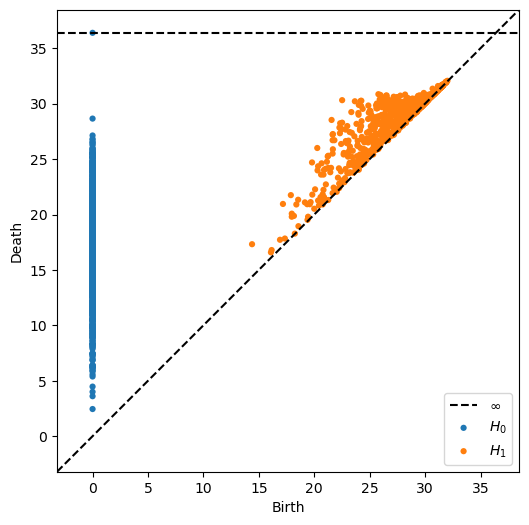

In [7]:
output = pipeline_trans(image_function = sine, num_pixels = 80, window_size = 4, n_isos= 1000, x_translate = 5, y_translate = 5, maxdim=1, coeff=3)
plot_dgms(output)

**This is not what I was hoping for...**

**Let's try a different tiling**

In [16]:
def rhombus(x,y): 
    ret = 0 
    for a in range(10):
        if (3 ** 0.5 * x - 0.1) + 2 * a * (3 ** 0.5) <= y <= (3 ** 0.5 * x + 0.1) + 2 * a * (3 ** 0.5):
            ret = 1
        if (3 ** 0.5 * x - 0.1) + 2 * (-a) * (3 ** 0.5) <= y <= (3 ** 0.5 * x + 0.1) + 2 * (-a) * (3 ** 0.5):
            ret = 1
        if (-3 ** 0.5 * x - 0.1)+ 2 * a * (3 ** 0.5) <= y <= (-3 ** 0.5 * x + 0.1) + 2 * a * (3 ** 0.5):
            ret = 1
        if (-3 ** 0.5 * x - 0.1)+ 2 * (-a) * (3 ** 0.5) <= y <= (-3 ** 0.5 * x + 0.1) + 2 * (-a) * (3 ** 0.5):
            ret = 1
    return ret

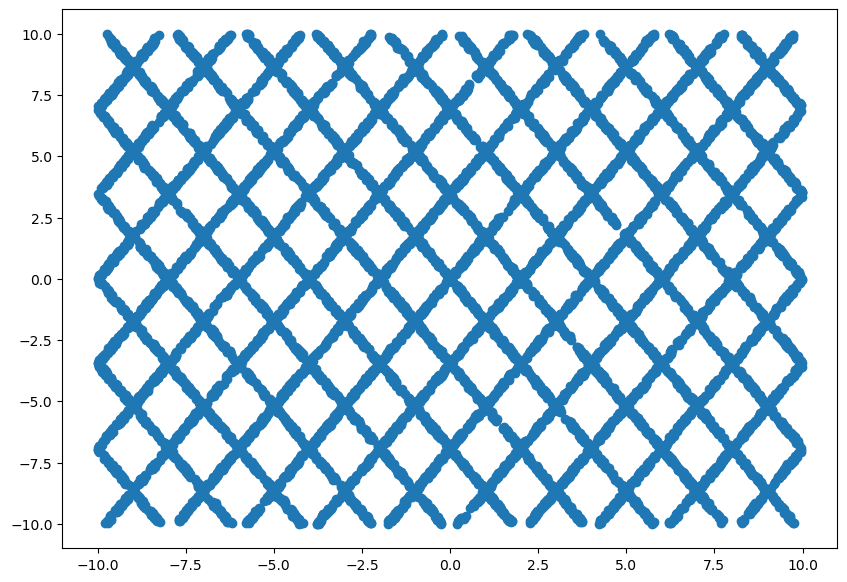

In [17]:
graph(rhombus, 10, 10, x_random = True, n_samples= 100000, y_random = True)

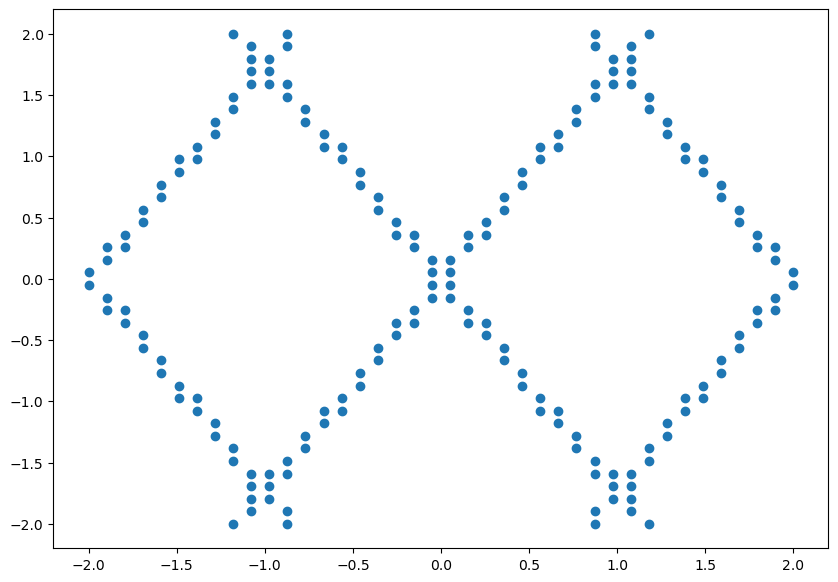

In [19]:
view_window(rhombus, 40, 4)

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


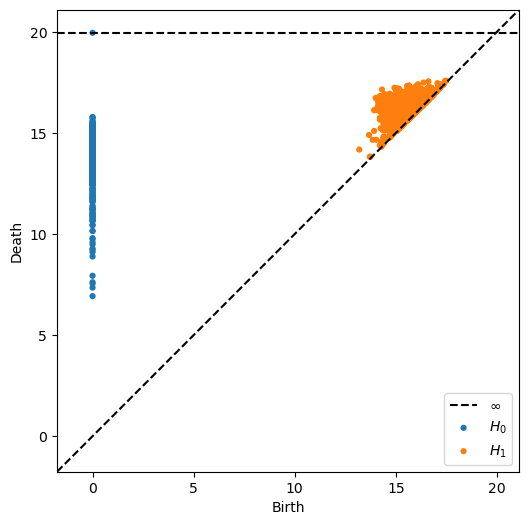

In [18]:
output = pipeline(image_function=rhombus, num_pixels=40, window_size=4, n_isos=1000, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

**this still looks bad, let's try messing around with how we generate the isometries**

In [126]:
# making sure rotations like pi/3, pi/2, ... are sampled 
def generate_isom2(n_isos, x_translate, y_translate):
    a = list(np.linspace(-x_translate/2, x_translate/2, n_isos)) 
    b = list(np.linspace(-y_translate/2, y_translate/2, n_isos)) 
    theta = (n_isos // 31 * (np.linspace(0, 2*pi, 31)).tolist())
    theta2 = (np.linspace(0, 2*pi, n_isos % 31)).tolist()
    for i in theta2:
        theta.append(i)

    isos = []
    isos_inv = []
    for i in range(n_isos):
        isos.append(isom(a[i], b[i], theta[i]))
        isos_inv.append(isom(-1 * a[i],-1 * b[i],2 * pi - theta[i])) 
    return isos_inv

In [125]:
np.linspace(0, 2*pi, 31)

array([0.        , 0.20943951, 0.41887902, 0.62831853, 0.83775804,
       1.04719755, 1.25663706, 1.46607657, 1.67551608, 1.88495559,
       2.0943951 , 2.30383461, 2.51327412, 2.72271363, 2.93215314,
       3.14159265, 3.35103216, 3.56047167, 3.76991118, 3.97935069,
       4.1887902 , 4.39822972, 4.60766923, 4.81710874, 5.02654825,
       5.23598776, 5.44542727, 5.65486678, 5.86430629, 6.0737458 ,
       6.28318531])

In [21]:
def pipeline2(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom2(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

/Users/oliviamcgough/opt/anaconda3/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


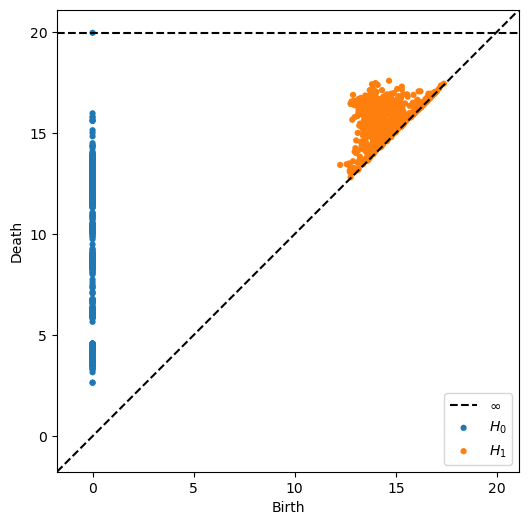

In [23]:
output = pipeline2(image_function=rhombus, num_pixels=40, window_size=4, n_isos=1000, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

still looks bad

In [26]:
# no longer trying for specific angles, just using linspace instead of random
def generate_isom3(n_theta, n_translates, x_translate, y_translate):
    a = list(np.linspace(-x_translate/2, x_translate/2, n_translates)) # sampling from (-x,x)
    b = list(np.linspace(-y_translate/2, y_translate/2, n_translates)) # sampling from (-y,y)
    theta = ((np.linspace(0, 2*pi, n_theta)).tolist())

    isos = []
    isos_inv = []
    for i in range(n_theta):
        for j in range(n_translates):
            for k in range(n_translates):
                isos.append(isom(a[j], b[k], theta[i]))
                isos_inv.append(isom(-1 * a[j],-1 * b[k],2 * pi - theta[i])) 
    return isos_inv

In [27]:
def pipeline3(image_function, num_pixels, window_size, n_theta, n_translates, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom3(n_theta, n_translates, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

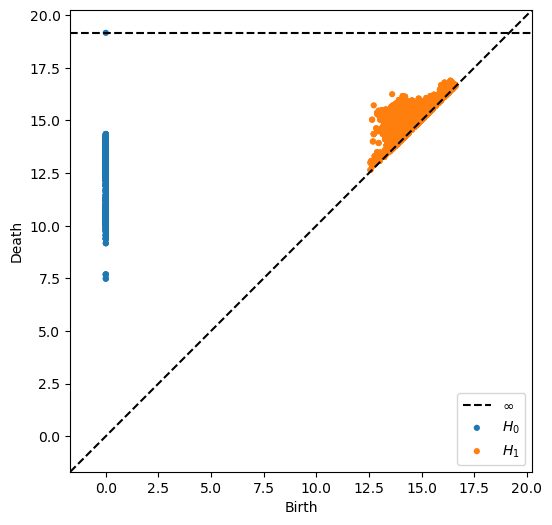

In [28]:
output = pipeline3(image_function=rhombus, num_pixels=40, window_size=4, n_theta=50, n_translates = 10, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

bad bad bad 

In [32]:
# making it so that pi/3, pi/2, ... are each sampled many times
def generate_isom4(n_theta, n_translates, x_translate, y_translate):
    a = list(np.linspace(-x_translate/2, x_translate/2, n_translates)) # sampling from (-x,x)
    b = list(np.linspace(-y_translate/2, y_translate/2, n_translates)) # sampling from (-y,y)
    theta = ((np.linspace(0, 2*pi, n_theta - (6 * (n_theta//18))).tolist()))
    theta2 = n_theta // 18 * [0, pi / 3, 2 * pi / 3, pi, 4 * pi / 3, 5 * pi / 3]
    
    for i in range(len(theta2)):
        theta.append(theta2[i])

    isos = []
    isos_inv = []
    for i in range(n_theta):
        for j in range(n_translates):
            for k in range(n_translates):
                isos.append(isom(a[j], b[k], theta[i]))
                isos_inv.append(isom(-1 * a[j],-1 * b[k],2 * pi - theta[i])) 
    return isos_inv

In [33]:
def pipeline4(image_function, num_pixels, window_size, n_theta, n_translates, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom4(n_theta, n_translates, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

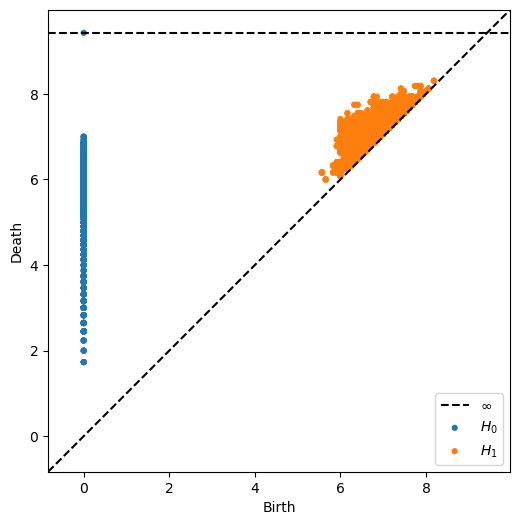

In [34]:
output = pipeline4(image_function=rhombus, num_pixels=20, window_size=2, n_theta=50, n_translates = 10, x_translate=2.5, y_translate=2.5, maxdim=1, coeff=2)
plot_dgms(output)

damn 

In [132]:
# making it so that pi/3, pi/2, ... are each sampled many times AND random translates
def generate_isom5(n_theta, n_translates, x_translate, y_translate):
    a = list(2 * x_translate * np.random.random(n_translates) - x_translate) # sampling from (-x,x)
    b = list(2 * y_translate * np.random.random(n_translates) - y_translate) # sampling from (-y,y)
    theta = ((np.linspace(0, 2*pi, n_theta - (6 * (n_theta//18))).tolist()))
    theta2 = n_theta // 18 * [0, pi / 3, 2 * pi / 3, pi, 4 * pi / 3, 5 * pi / 3]
    
    for i in range(len(theta2)):
        theta.append(theta2[i])

    isos = []
    isos_inv = []
    for i in range(n_theta):
        for j in range(n_translates):
            for k in range(n_translates):
                isos.append(isom(a[j], b[k], theta[i]))
                isos_inv.append(isom(-1 * a[j],-1 * b[k],2 * pi - theta[i])) 
    return isos_inv

In [133]:
def pipeline5(image_function, num_pixels, window_size, n_theta, n_translates, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom5(n_theta, n_translates, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    output = p_hom(M, maxdim, coeff)
    return output

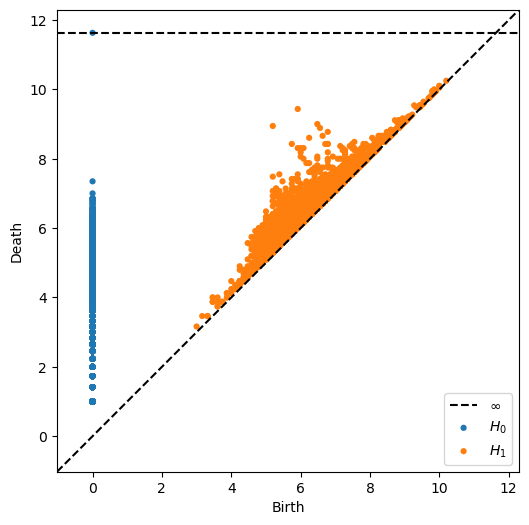

In [134]:
output = pipeline5(image_function=sine, num_pixels=20, window_size=2, n_theta=50, n_translates = 10, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

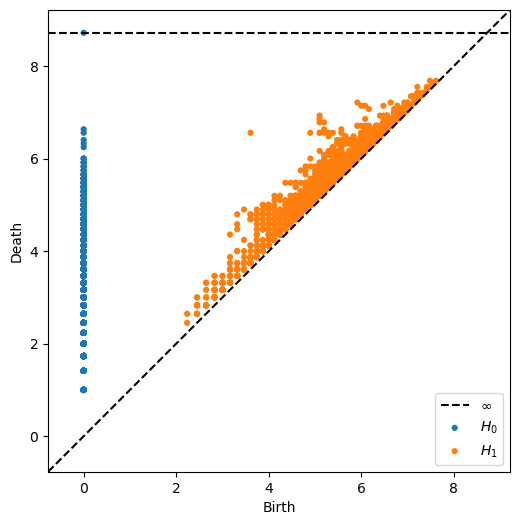

In [140]:
output = pipeline5(image_function=sine, num_pixels=20, window_size=2, n_theta=60, n_translates = 10, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

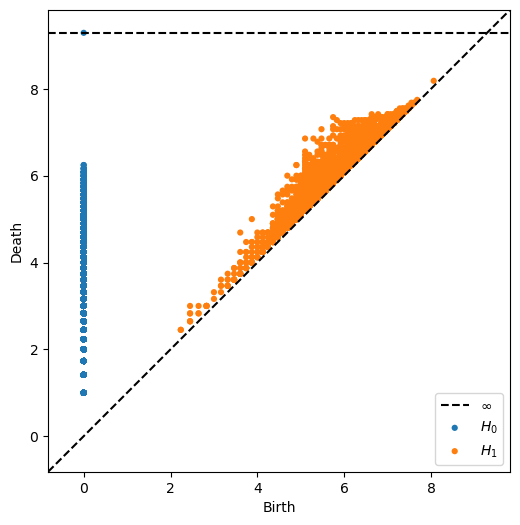

In [142]:
output = pipeline5(image_function=sine, num_pixels=20, window_size=2, n_theta=70, n_translates = 10, x_translate=5, y_translate=5, maxdim=1, coeff=2)
plot_dgms(output)

nope not that either 

## Maybe blurring will help?
## Turn to PIL image then blur and convert back?

In [10]:
import PIL
from PIL import Image, ImageFilter 
from numpy import asarray

In [11]:
def matrix(image_function, num_pixels, window_size, n_isos, x_translate, y_translate):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    return M

In [12]:
def view_isom(vector, pixels):
    vector.reshape(50,50)
    
    x_points = 50 * list(np.linspace(-10, 10, 50))
    y_points = 50 * list(np.linspace(-10, 10, 50))
    y_points.sort()
    
    fig = plt.figure(figsize = (7, 7))
    ax = plt.axes()
    ax.scatter(x_points, y_points, c = vector)
    plt.show()

### tangent on how *quirky* the PIL fromarray function is 

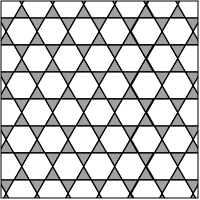

In [4]:
image = Image.open("/Users/oliviamcgough/Documents/Persistent Symmetry /persistent-symmetry/studentDemos/images/david_tiling.png")
image

In [10]:
image2 = image.convert('1')
A_bw = asarray(image2)
A_bw

array([[False, False, False, ..., False, False,  True],
       [False, False,  True, ..., False, False,  True],
       [False,  True,  True, ...,  True, False,  True],
       ...,
       [False, False,  True, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

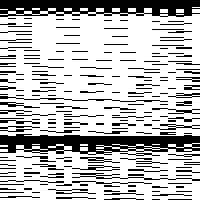

In [11]:
Image.fromarray(A_bw, mode = '1')

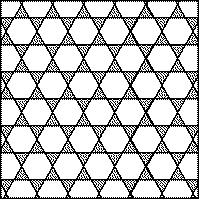

In [12]:
Image.fromarray(A_bw)

In [13]:
image3 = image.convert('L')
A_grey = asarray(image3)
A_grey

array([[  0,   0,   0, ...,   0,   0, 255],
       [  0,  63, 127, ...,  63,   0, 255],
       [  0, 127, 255, ..., 127,   0, 255],
       ...,
       [  0,  63, 127, ...,  63,   0, 255],
       [  0,   0,   0, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

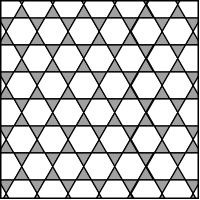

In [14]:
Image.fromarray(A_grey, mode = 'L')

In [15]:
A_rgb = asarray(image)
A_rgb

array([[[  0,   0,   0,  64],
        [  0,   0,   0, 128],
        [  0,   0,   0, 128],
        ...,
        [  0,   0,   0, 128],
        [  0,   0,   0,  64],
        [255, 255, 255,   0]],

       [[  0,   0,   0, 128],
        [ 63,  63,  63, 255],
        [127, 127, 127, 255],
        ...,
        [ 63,  63,  63, 255],
        [  0,   0,   0, 128],
        [255, 255, 255,   0]],

       [[  0,   0,   0, 128],
        [127, 127, 127, 255],
        [255, 255, 255, 255],
        ...,
        [127, 127, 127, 255],
        [  0,   0,   0, 128],
        [255, 255, 255,   0]],

       ...,

       [[  0,   0,   0, 128],
        [ 63,  63,  63, 255],
        [127, 127, 127, 255],
        ...,
        [ 63,  63,  63, 255],
        [  0,   0,   0, 128],
        [255, 255, 255,   0]],

       [[  0,   0,   0,  64],
        [  0,   0,   0, 128],
        [  0,   0,   0, 128],
        ...,
        [  0,   0,   0, 128],
        [  0,   0,   0,  64],
        [255, 255, 255,   0]],

       [[255

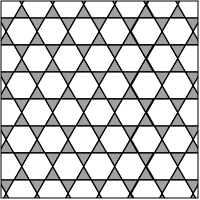

In [16]:
Image.fromarray(A_rgb)

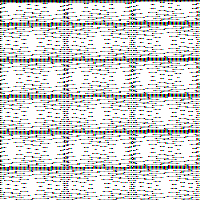

In [17]:
Image.fromarray(A_rgb, mode = "RGB")

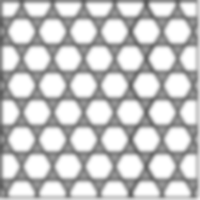

In [18]:
im2 = image.filter(ImageFilter.GaussianBlur(radius = 2))
im2

In [15]:
M = matrix(image_function = sine, num_pixels = 50, window_size = 4, n_isos= 1000, x_translate = 5, y_translate = 5)

In [16]:
M

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
M.shape

(1000, 2500)

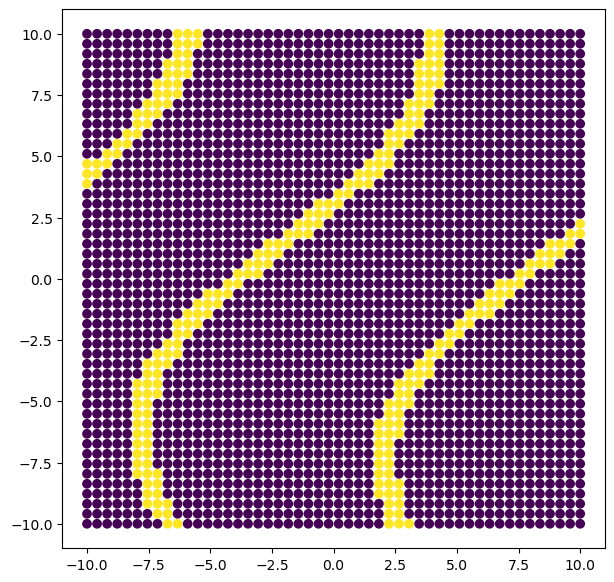

In [21]:
M0 = M[0]
view_isom(M0, 50)

In [23]:
M0 = M[0].reshape(50,50)
np.max(M0)

1

In [24]:
M0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
type(M[0][0])

numpy.int64

In [24]:
M0.astype(bool) 

array([[False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [25]:
type(M0.astype(bool)[0][0])

numpy.bool_

In [26]:
Image.fromarray(M0)

TypeError: Cannot handle this data type: (1, 1), <i8

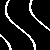

In [27]:
Image.fromarray(M0.astype(bool))

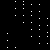

In [28]:
Image.fromarray(M0.astype(bool), mode = '1')

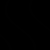

In [29]:
Image.fromarray(M0.astype(bool), mode = 'L')

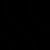

In [30]:
Image.fromarray(M0.astype(bool), mode = 'P')

In [31]:
Image.fromarray(M0.astype(bool), mode = 'I')

ValueError: not enough image data

In [32]:
Image.fromarray(M0.astype(bool), mode = 'F')

ValueError: not enough image data

In [33]:
Image.fromarray(M0.astype(bool), mode = 'RGB')

ValueError: not enough image data

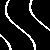

In [34]:
Muint8 = np.uint8((M0)*255)
im = Image.fromarray(Muint8)
im 

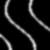

In [35]:
im.filter(ImageFilter.GaussianBlur(radius = 1))

In [48]:
Image.fromarray(Muint8, mode = 'HSV')

ValueError: not enough image data

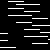

In [36]:
Image.fromarray(Muint8, mode = '1')

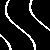

In [49]:
Image.fromarray(Muint8, mode = 'L')

In [38]:
M0225 = M0 * 255

In [39]:
M0225

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [40]:
Image.fromarray(M0225)

TypeError: Cannot handle this data type: (1, 1), <i8

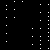

In [41]:
Image.fromarray(M0225, mode = 'L')

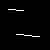

In [42]:
PIL_image = Image.fromarray(M0225, '1')
PIL_image

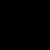

In [43]:
PIL_image = Image.fromarray(M0225, 'I')
PIL_image

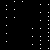

In [44]:
PIL_image = Image.fromarray(M0225, 'P')
PIL_image

In [45]:
PIL_image = Image.fromarray(M0225, 'F')
PIL_image

ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=50x50>

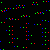

In [58]:
PIL_image = Image.fromarray(M0225, 'RGB')
PIL_image

### ... end of tangent

### now we see if blurring helps

In [24]:
def blurred(vector):
    num_pix = int(len(vector) ** (0.5))
    vector = vector.reshape(num_pix,num_pix)
    Muint8 = np.uint8((vector)*255)
    image = Image.fromarray(Muint8)
    image2 = image.filter(ImageFilter.GaussianBlur(radius = .5))
    return image2

In [22]:
def vector_blurred(vector):
    image = blurred(vector)
    array = asarray(image)
    vector = np.concatenate(array)
    return vector 

In [23]:
blurred(M[0], 50)

TypeError: blurred() takes 1 positional argument but 2 were given

In [88]:
array = asarray(blurred(M[0], 50))
array 

array([[ 85,  68,  37, ...,   0,   0,   0],
       [159, 138,  97, ...,   0,   0,   0],
       [164, 164, 157, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

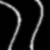

In [96]:
returned_image = Image.fromarray(array)
returned_image

In [143]:
returned_image.size

(50, 50)

In [35]:
def pipeline_blur(image_function, num_pixels, window_size, n_isos, x_translate, y_translate, maxdim, coeff):
    pixels = get_pixels(num_pixels, window_size)
    isos_inv = generate_isom(n_isos, x_translate, y_translate)
    M = matrix_of_images(pixels, isos_inv, image_function)
    M = np.apply_along_axis(vector_blurred, 1, M)
    output = p_hom(M, maxdim, coeff)
    return output

In [10]:
def thick_sine(x,y):
    ret = 0
    for a in range(-10,10):
        if sin(x) - 0.2 + 2*a <= y <= sin(x) + 0.2 + 2*a:
            ret = 1
    return ret

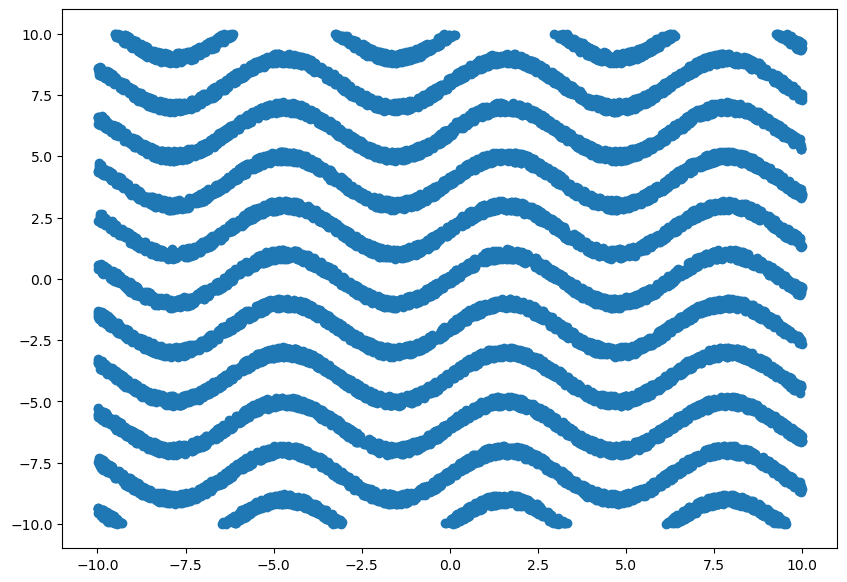

In [219]:
graph(thick_sine,10,10)

In [224]:
pixels = get_pixels(num_pixels=40, window_size=4)
isos_inv = generate_isom(n_isos=100, x_translate=10, y_translate=10)
M = matrix_of_images(pixels, isos_inv, image_function=thick_sine)
M = np.apply_along_axis(vector_blurred, 1, M)

In [225]:
M

array([[  1,  15,  75, ...,   0,   0,   1],
       [  0,   0,   0, ...,   1,   0,   0],
       [191, 115,  43, ...,   0,   0,   0],
       ...,
       [243, 239, 200, ...,  10,   1,   0],
       [255, 255, 253, ...,   0,   0,   0],
       [148, 206, 245, ..., 238, 238, 238]], dtype=uint8)

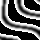

In [226]:
Image.fromarray(np.uint8((M[0].reshape(40,40))*255))

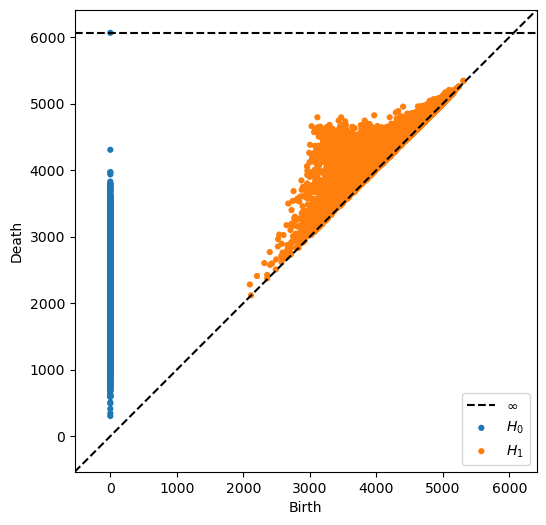

In [11]:
output = pipeline_blur(image_function = thick_sine, num_pixels = 50, window_size = 4, n_isos= 4000, x_translate = 10, y_translate = 10, maxdim = 1, coeff = 2)
plot_dgms(output)

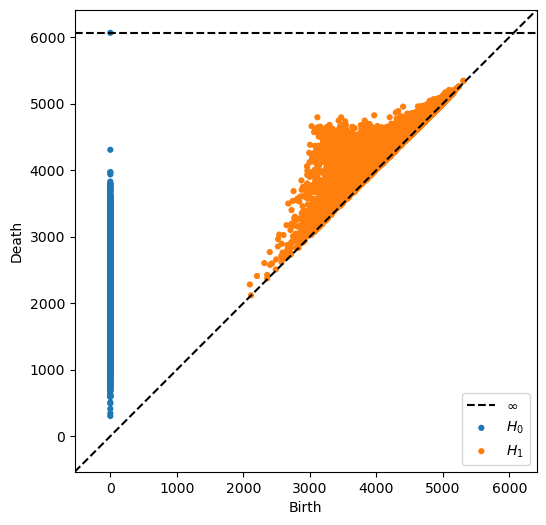

In [12]:
plot_dgms(output)

In [13]:
# doesnt look like blurring helped

In [1]:
def hook(x,y):
    ret = 0
    if 0<= x % 1 < 0.1:
        ret = 1
    if y % 1 > 0.8 and 0 < x % 1 < 0.5:
        ret = 1
    return ret

In [31]:
pixels = get_pixels(num_pixels=40, window_size=2)
isos_inv = generate_isom(n_isos=100, x_translate=10, y_translate=10)
M = matrix_of_images(pixels, isos_inv, image_function=hook)
blurM = np.apply_along_axis(vector_blurred, 1, M)
blurM

array([[  1,  28, 225, ...,   0,   0,   0],
       [255, 255, 254, ...,  29, 227, 253],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 254],
       [ 56, 225, 202, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [32]:
M

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

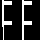

In [33]:
Image.fromarray(np.uint8((M[0].reshape(40,40))*255))

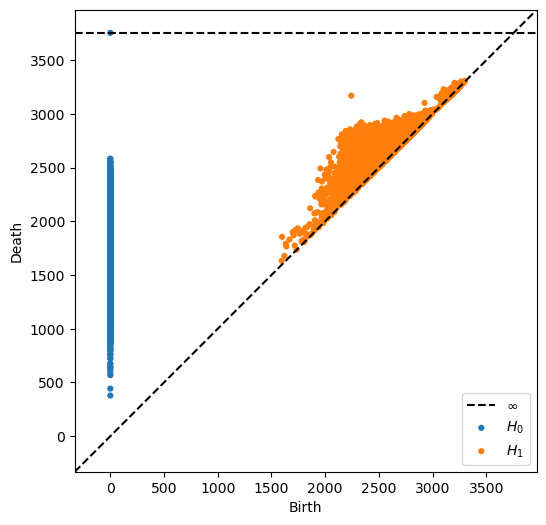

In [36]:
output = pipeline_blur(image_function = hook, num_pixels = 30, window_size = 2, n_isos= 4000, x_translate = 10, y_translate = 10, maxdim = 1, coeff = 2)
plot_dgms(output)

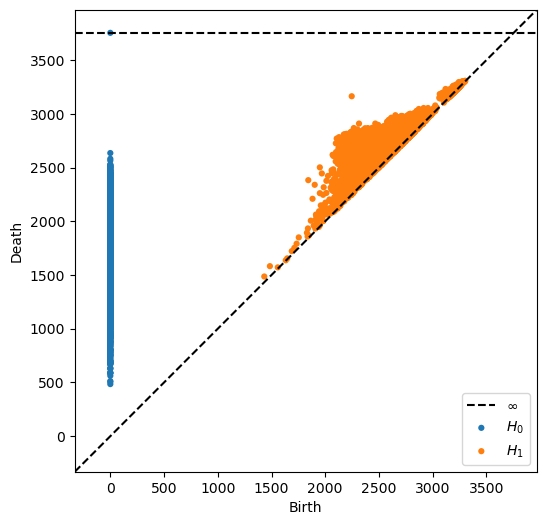

In [37]:
output = pipeline_blur(image_function = hook, num_pixels = 30, window_size = 2, n_isos= 4000, x_translate = 10, y_translate = 10, maxdim = 1, coeff = 3)
plot_dgms(output)